 ## 상품명 : 미래에셋대우 공모 ELS 26011회 조기상환형 조건충족시 연 7.5%(세전) / 최대손실률 -100%
## 상품정보 : https://www.miraeassetdaewoo.com/ 접속 후 상품정보>ELS 검색에서 날짜 2018/06/08에 26011
## 기초지수 : S&P500 - HSECI - EUROSTOXX50

In [6]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from time import perf_counter
from numba import jit
import warnings
warnings.filterwarnings(action='ignore') 
inv     = np.linalg.inv

In [14]:
UnderlyingXYZ = ['EURO STOXX 50','홍콩 H','S&P 500']
CurrencyXYZ = ['EUR','HKD','USD']
pricing_date = '2018-06-08'
AC_date = ['2018-12-03','2019-05-31','2019-12-02','2020-06-02','2020-12-02','2021-06-21']

In [16]:
path_price = r'C:\Users\ciiad\3d_ELS\가격데이터.xlsx'
path_interest =  r'C:\Users\ciiad\3d_ELS\cleaned_yield_curve.xlsx'
path_vol = r'C:\Users\ciiad\3d_ELS\cleaned_imvol_surface.xlsx'

In [15]:
price_data = pd.read_excel(r'C:\Users\ciiad\3d_ELS\가격데이터.xlsx').set_index('Symbol Name').T.iloc[5:]
price_data.index = pd.to_datetime(price_data.index)
return_data = price_data.resample('M').last().pct_change().iloc[1:][:pricing_date]
Corr_data = return_data[UnderlyingXYZ].ewm(alpha = 0.02).corr().loc[return_data.index[-1]]
Corr_data

Symbol Name,EURO STOXX 50,홍콩 H,S&P 500
Symbol Name,,,
EURO STOXX 50,1.000000,0.427120,0.705533
홍콩 H,0.427120,1.000000,0.604316
S&P 500,0.705533,0.604316,1.000000


In [1]:
path_interest = r'C:\Users\ciiad\3d_ELS\cleaned_yield_curve.xlsx'

### BS PDE 3 Asset

$$
\begin{array}{c}
\\
\ u_{\tau} = (r-d_{x})xu_{x} + (r-d_{y})yu_{y} + (r-d_{z})zu_{z} \\
\ + \frac{1}{2}(\sigma_{x}x)^{2}u_{xx} + \frac{1}{2}(\sigma_{y}y)^{2}u_{yy} + \frac{1}{2}(\sigma_{z}z)^{2}u_{zz}\\
\ + \rho_{xy}\sigma_{x}\sigma_{y}xyu_{xy} + \rho_{yz}\sigma_{y}\sigma_{z}yzu_{yz}+ \rho_{xz}\sigma_{z}\sigma_{x}zxu_{xz} - ru \\\
\\
\ u_{\tau}  = (1) + (2) + (3) \\  \\
(1) \ \ = (r-d_{x})xu_{x}+ \frac{1}{2}(\sigma_{x}x)^{2}u_{xx}+ \frac{1}{3}\rho_{xy}\sigma_{x}\sigma_{y}xyu_{xy} 
\  + \frac{1}{3}\rho_{yz}\sigma_{y}\sigma_{z}xyu_{yz}+ \frac{1}{3}\rho_{xz}\sigma_{z}\sigma_{x}xyu_{xz} - \frac{1}{3} ru \\
(2) \ \ = (r-d_{y})xu_{y}+ \frac{1}{2}(\sigma_{y}y)^{2}u_{yy}+ \frac{1}{3}\rho_{xy}\sigma_{x}\sigma_{y}xyu_{xy} 
\  + \frac{1}{3}\rho_{yz}\sigma_{y}\sigma_{z}xyu_{yz}+ \frac{1}{3}\rho_{xz}\sigma_{z}\sigma_{x}xyu_{xz} - \frac{1}{3} ru \\
(3) \ \ = (r-d_{z})xu_{z}+ \frac{1}{2}(\sigma_{z}z)^{2}u_{zz}+ \frac{1}{3}\rho_{xy}\sigma_{x}\sigma_{y}xyu_{xy} 
\  + \frac{1}{3}\rho_{yz}\sigma_{y}\sigma_{z}xyu_{yz}+ \frac{1}{3}\rho_{xz}\sigma_{z}\sigma_{x}xyu_{xz} - \frac{1}{3} ru \\
\end{array}
$$
### Assumption
$$
\begin{array}{c}
\ \Delta t = h \ , \ \Delta X = \Delta Y = \Delta Z , \ [if \  m = 0 : \ maturity, \ elif \  m = M \ : \ current\ price]  
\end{array}
$$
### Difference Equation Transform:

$$
\begin{array}{c}
U_{\tau} \ \ : \ \frac{U_{n_x , n_y , n_z }^{m+1} - U_{n_x , n_y, n_z}}{h} \\
(r-d_x )xu_x \ \ : \ (r-d_x ) (n_x \Delta X) (\frac{U_{n_x +1 , n_y , n_z }^{m+1} - U_{n_x , n_y, n_z}^{m+1}}{\Delta X})  \ : backward \\
\frac{1}{2} (\sigma_x x)^2 u_{xx} \ \ : \frac{(\sigma_x n_x)^2}{2} (U_{n_x +1 , n_y , n_z}^{m+1} - 2 U_{n_x , n_y, n_z}^{m+1} + U_{n_x -1, n_y , n_z }^{m+1})\ : backward \\
\rho_{xy} \sigma_x \sigma_y xy u_{xy} \ \ : \frac{1}{4}(U_{n_x +1 , n_y +1 , n_z}^{m} + U_{n_x -1 , n_y -1, n_z}^{m} - U_{n_x +1, n_y -1, n_z}^{m} - U_{n_x -1, n_y +1 , n_z}^{m}) \ : forward
\end{array}
$$

### Operator Splitting :

$$
\begin{array}{1c}
\frac{U_{n_x , n_y , n_z }^{m+1} - U_{n_x , n_y, n_z}}{h} = \frac{U_{n_x , n_y , n_z }^{m+\frac{1}{3}} - U_{n_x , n_y, n_z}^{m}}{h} + \frac{U_{n_x , n_y , n_z }^{m+\frac{2}{3}} - U_{n_x , n_y, n_z}^{m+\frac{1}{3}}}{h}  + \frac{U_{n_x , n_y , n_z }^{m+1} - U_{n_x , n_y, n_z}^{m+\frac{2}{3}}}{h} = (1) + (2) + (3)
\end{array}
$$

 #### (1) Implicit for x (From m to m + 1/3)
 

$$
\begin{array}{c}
\frac{U_{n_x , n_y , n_z }^{m+\frac{1}{3}} - U_{n_x , n_y, n_z}^{m}}{h} \\
=(r-d_{x})n_x (U_{n_x +1 , n_y, n_z}^{m+\frac{1}{3}}-U_{n_x , n_y, n_z}^{m+\frac{1}{3}})+ \frac{1}{2}(\sigma_{x}n_x)^{2}(U_{n_x +1, n_y, n_z}^{m+\frac{1}{3}}-2U_{n_x , n_y, n_z}^{m+\frac{1}{3}} + U_{n_x -1, n_y, n_z}^{m+\frac{1}{3}}) \\ + \frac{1}{3}\rho_{xy}\sigma_{x}\sigma_{y} \frac{1}{4}(U_{n_x +1, n_y +1, n_z}^{m} + U_{n_x -1, n_y -1, n_z }^{m} - U_{n_x +1, n_y -1, n_z }^{m} - U_{n_x -1 , n_y +1, n_z }^{m}) \\ 
+ \frac{1}{3}\rho_{yz}\sigma_{y}\sigma_{z} \frac{1}{4}(U_{n_x +1, n_y, n_z +1}^{m} + U_{n_x -1, n_y , n_z -1 }^{m} - U_{n_x +1, n_y , n_z -1}^{m} - U_{n_x -1 , n_y , n_z +1}^{m}) \\ 
+ \frac{1}{3}\rho_{xz}\sigma_{x}\sigma_{z} \frac{1}{4}(U_{n_x, n_y +1, n_z +1}^{m} + U_{n_x , n_y -1, n_z -1}^{m} - U_{n_x , n_y +1, n_z -1}^{m} - U_{n_x , n_y -1, n_z +1}^{m})
\end{array}
$$

 ####   Parameters (From m to m + 1/3)
$$
\begin{array}{c}
B_{n_x} U_{n_x -1, n_y , n_z }^{m+\frac{1}{3}} + A_{n_x} U_{n_x, n_y , n_z }^{m+\frac{1}{3}} + C_{n_x} U_{n_x +1, n_y , n_z }^{m+\frac{1}{3}} = d_{n_x , n_y , n_z}^{m}
\\ ----------------------------- \\
A_{n_x} = 1 + h(\frac{1}{3} r + (r-D_x) n_x + (\sigma_x n_x)^2) \\
B_{n_x} = -0.5 (\sigma_x n_x )^2 h \\
C_{n_x} = -0.5(\sigma_x n_x )^2 h - (r-D_x ) n_x \bullet h
\\
\\ \\
d_{n_x , n_y , n_z}^{m} = U_{n_x , n_y , n_z}^{m} \\ \ + \frac{1}{3}\rho_{xy}\sigma_{x}\sigma_{y} \bullet h \frac{1}{4}(U_{n_x +1, n_y +1, n_z}^{m} + U_{n_x -1, n_y -1, n_z }^{m} - U_{n_x +1, n_y -1, n_z }^{m} - U_{n_x -1 , n_y +1, n_z }^{m}) \\ 
+ \frac{1}{3}\rho_{yz}\sigma_{y}\sigma_{z} \bullet h \frac{1}{4}(U_{n_x +1, n_y, n_z +1}^{m} + U_{n_x -1, n_y , n_z -1 }^{m} - U_{n_x +1, n_y , n_z -1}^{m} - U_{n_x -1 , n_y , n_z +1}^{m}) \\ 
+ \frac{1}{3}\rho_{xz}\sigma_{x}\sigma_{z} \bullet h \frac{1}{4}(U_{n_x, n_y +1, n_z +1}^{m} + U_{n_x , n_y -1, n_z -1}^{m} - U_{n_x , n_y +1, n_z -1}^{m} - U_{n_x , n_y -1, n_z +1}^{m})
\\
\\
\begin{bmatrix} b_1 + 2a_1 & c_1-a_1 & 0 & 0& .. & 0& 0 & 0\\ a_2 & b_2 & c_2& 0& ..& 0 & 0& 0 \\ 0 & a_3 & b_3& c_3& ..& 0 & 0& 0\\ 0 & 0 & a_4& b_4& ..& 0& 0& 0\\ .. & .. & ..& ..& ..& 0& 0& 0\\ .. & .. & ..& ..& ..& a_{N-2} & b_{N-2}& c_{N-2}\\ 0 & 0 & 0& 0& 0& 0& a_{N-1}-c_{N-1}& b_{N-1}+2c_{N-1} \end{bmatrix} U_{n_x, n_y, n_z}^{m+\frac{1}{3}} = d_{n_x , n_y, n_z}^{m}
\\
\\
(Inv \ tridiag_{n_x})^{-1} \bullet d_{n_x , n_y, n_z}^{m} = u_{n_x ,n_y, n_z}^{m+\frac{1}{3}}
\\
\end{array}
$$

##### Boundary Condition 
$$
\begin{array}{c}
U_{N} \ = \  2U_{N-1} - U_{N-2} \\ 
U_{N} \ >= \ max(U_{N-1}\ , \ U_{N-2}) \\ \\
\end{array}
$$

 #### (2) Implicit for y and Parameters (From m +1/3 to m + 2/3)
$$
\begin{array}{c}
B_{n_y} U_{n_x , n_y -1 , n_z }^{m+\frac{2}{3}} + A_{n_y} U_{n_x, n_y , n_z }^{m+\frac{2}{3}} + C_{n_x} U_{n_x , n_y +1, n_z }^{m+\frac{2}{3}} = d_{n_x , n_y , n_z}^{m + \frac{1}{3}}
\\ ----------------------------- \\
A_{n_y} = 1 + h(\frac{1}{3} r + (r-D_y) n_y + (\sigma_y n_y)^2) \\
B_{n_y} = -0.5 (\sigma_y n_y )^2 h \\
C_{n_y} = -0.5(\sigma_y n_y )^2 h - (r-D_y ) n_y \bullet h
\\
(Inv \ tridiag_{n_y})^{-1} \bullet d_{n_x , n_y, n_z}^{m+\frac{1}{3}} = u_{n_x ,n_y, n_z}^{m+\frac{2}{3}}
\end{array}
$$ 
 
 #### (3) Implicit for z and Parameters (From m +2/3 to m + 1)
$$
\begin{array}{c}
B_{n_z} U_{n_x , n_y , n_z -1}^{m+1} + A_{n_y} U_{n_x, n_y , n_z }^{m+1} + C_{n_x} U_{n_x , n_y , n_z +1}^{m+1} = d_{n_x , n_y , n_z}^{m+\frac{2}{3}}
\\ ----------------------------- \\
A_{n_z} = 1 + h(\frac{1}{3} r + (r-D_z) n_z + (\sigma_z n_z)^2) \\
B_{n_z} = -0.5 (\sigma_z n_z )^2 h \\
C_{n_z} = -0.5(\sigma_z n_z )^2 h - (r-D_z ) n_z \bullet h
\\
(Inv \ tridiag_{n_z})^{-1} \bullet d_{n_x , n_y, n_z}^{m+\frac{2}{3}} = u_{n_x ,n_y, n_z}^{m+1}
\end{array}
$$  

 #### ELS Pricing sequence :
$$
\begin{array}{c}
for \ m \ in \ range(T/h) \ : \ \ \ \ \ \ \ \ \ \ \ \ \ \
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \\
 U(KI)_{n_x ,n_y, n_z}^{m+\frac{1}{3}}  = Inv \ tridiag( n_x, \tau , KI = True)^{-1} \bullet d_{n_x , n_y, n_z}^{m} \ S.\ T.\ Boundary\ \\
U(KI)_{n_x ,n_y, n_z}^{m+\frac{2}{3}} = Inv \ tridiag( n_y, \tau , KI = True)^{-1} \bullet d_{n_x , n_y, n_z}^{m+\frac{1}{3}}\ S.\ T.\ Boundary\ \\ 
U(KI)_{n_x ,n_y, n_z}^{m+1} = Inv \ tridiag( n_z, \tau , KI = True)^{-1} \bullet d_{n_x , n_y, n_z}^{m+\frac{2}{3}}\ S.\ T.\ Boundary\ \\
--------------------------
\\
U(NKI)_{n_x ,n_y, n_z}^{m+\frac{1}{3}} = Inv \ tridiag( n_x, \tau , KI = False)^{-1} \bullet d_{n_x , n_y, n_z}^{m} \ S.\ T.\ Boundary \\
U(NKI)_{n_x ,n_y, n_z}^{m+\frac{2}{3}} = Inv \ tridiag( n_y, \tau , KI = False)^{-1} \bullet d_{n_x , n_y, n_z}^{m+\frac{1}{3}} \ S.\ T.\ Boundary \\ 
U(NKI)_{n_x ,n_y, n_z}^{m+1} = Inv \ tridiag( n_z, \tau , KI = False)^{-1} \bullet d_{n_x , n_y, n_z}^{m+\frac{2}{3}} \ S.\ T.\ Boundary \\
--------------------------
\\
Overwrite \  the \ NKI \ Matrix \ below \ Barier \ with \ KI \ Matrix \\
Overwrite \ Autocall \ Payoff \  at\  Autocall \ date\\
\end{array}
$$  

In [3]:
def Calculate_w(path, Tickers) :
    params_list = []
    for i in Tickers :
        data = pd.read_excel(path , sheet_name=i, index_col= 0)
        vol = pd.DataFrame(np.array(data).reshape(-1), columns= ['VOL'])
        S = pd.DataFrame(np.array(np.repeat(data.index, 6)) , columns= ['S'])
        my_data = pd.concat([S,vol], axis = 1)
        y = my_data['VOL']
        x = 1/np.sqrt(my_data['S'])
        result = sm.OLS(y,x).fit()    
        params_list.append(result.params['S'])
    return tuple(params_list)

def Fd_rate(r_curve, T, Coupon_Freq = 0.5) : 
    ###################################################
    ## description : Calculate Forward Interest Rate ##
    ###################################################    
    t = np.arange(Coupon_Freq, T+Coupon_Freq, Coupon_Freq)
    Frate = np.concatenate([r_curve[0:1],((r_curve*t)[1:] - (r_curve*t)[:-1])/Coupon_Freq])
    return Frate

def Calculate_F_Vol(std_x_K, std_x_KI, T, Coupon_Freq = 0.5) :
    #########################################    
    ## description : Calculate Forward Vol ##
    #########################################    
    t = np.arange(Coupon_Freq, T+Coupon_Freq, Coupon_Freq)    
    F_Vol_x_KI = np.concatenate([std_x_K[0:1],
                                np.sqrt( np.maximum(((std_x_K**2 * t)[1:] - (std_x_K**2 * t)[:-1])/Coupon_Freq ,0.01) )])
    F_Vol_x_NKI = np.concatenate([std_x_K[0:1],
                                 np.sqrt(np.maximum(((np.r_[std_x_K[:-1], std_x_KI[-1]]**2 * t)[1:] -
                                                     (np.r_[std_x_K[:-1], std_x_KI[-1]]**2 * t)[:-1])/Coupon_Freq, 0.01))])
    return F_Vol_x_KI, F_Vol_x_NKI

def Inv_tdiag(h,r,D,n,sig,rounding = 6 , dtype = np.float32) :
    ########################################################    
    ## description : Calculate Inverse Tridiagonal Matrix ##
    ########################################################    
    a_n = 1 + h * (1/3 * r + (r-D)*n + (sig * n)**2)
    b_n = -0.5 * (sig * n)**2 * h
    c_n = -0.5 * (sig * n)**2 * h - (r-D) * n * h    
    a_n[0], a_n[-1]  = a_n[0]  + 2*b_n[0] , a_n[-1] + 2*c_n[-1]
    c_n[0], b_n[-1] = c_n[0]  - b_n[0] , b_n[-1] - c_n[-1]
    k= np.array([b_n[1:], a_n, c_n[:-1]])
    offset      = [-1,0,1]
    diag        = diags(k,offset, dtype = dtype).toarray()
    return np.linalg.inv(diag).round(rounding)
@jit
def Calculate_d(U_tau, n_asset1, n_asset2, n_asset3, sig1, sig2, sig3, rho12, rho23, rho13, h) :
    #################################################
    ## description : Calculate d(n_x, n_y, n_z, t) ##
    #################################################
    U_n1n2n3 = U_tau[1:-1,1:-1,1:-1] 
    u_crs_12 = (U_tau[2:,2:,1:-1] + U_tau[:-2,:-2,1:-1] - U_tau[:-2,2:,1:-1] - U_tau[2:,:-2,1:-1])
    u_crs_13 = (U_tau[2:,1:-1,2:] + U_tau[:-2,1:-1,:-2] - U_tau[:-2,1:-1,2:] - U_tau[2:,1:-1,:-2])
    u_crs_23 = (U_tau[1:-1,2:,2:] + U_tau[1:-1,:-2,:-2] - U_tau[1:-1,:-2,2:] - U_tau[1:-1,2:,:-2])
    n1_n2 = (n_asset1[1:-1].reshape(-1,1,1) * n_asset2[1:-1].reshape(1,-1,1))
    n1_n3 = (n_asset1[1:-1].reshape(-1,1,1) * n_asset3[1:-1].reshape(1,1,-1))
    n2_n3 = (n_asset2[1:-1].reshape(1,-1,1) * n_asset3[1:-1].reshape(1,1,-1))
    d_IFDM1= (U_n1n2n3 +                     
              1/12 * rho12 * sig1 * sig2 * n1_n2 * h * u_crs_12 +
              1/12 * rho13 * sig1 * sig3 * n1_n3 * h * u_crs_13 +
              1/12 * rho23 * sig2 * sig3 * n2_n3 * h * u_crs_23)        
    return d_IFDM1
@jit
def Calculate_d_CEV(U_tau, n_asset1, n_asset2, n_asset3, sig1, sig2, sig3, rho12, rho23, rho13, h) :
    #################################################
    ## description : Calculate d(n_x, n_y, n_z, t) ##
    #################################################
    U_n1n2n3 = U_tau[1:-1,1:-1,1:-1] 
    u_crs_12 = (U_tau[2:,2:,1:-1] + U_tau[:-2,:-2,1:-1] - U_tau[:-2,2:,1:-1] - U_tau[2:,:-2,1:-1])
    u_crs_13 = (U_tau[2:,1:-1,2:] + U_tau[:-2,1:-1,:-2] - U_tau[:-2,1:-1,2:] - U_tau[2:,1:-1,:-2])
    u_crs_23 = (U_tau[1:-1,2:,2:] + U_tau[1:-1,:-2,:-2] - U_tau[1:-1,:-2,2:] - U_tau[1:-1,2:,:-2])
    n1_n2 = (n_asset1[1:-1].reshape(-1,1,1) * n_asset2[1:-1].reshape(1,-1,1))
    n1_n3 = (n_asset1[1:-1].reshape(-1,1,1) * n_asset3[1:-1].reshape(1,1,-1))
    n2_n3 = (n_asset2[1:-1].reshape(1,-1,1) * n_asset3[1:-1].reshape(1,1,-1))
    d_IFDM1= (U_n1n2n3 +                     
              1/12 * rho12 * sig1.reshape(-1,1,1) * sig2.reshape(1,-1,1) * n1_n2 * h * u_crs_12 +
              1/12 * rho13 * sig1.reshape(-1,1,1) * sig3.reshape(1,1,-1) * n1_n3 * h * u_crs_13 +
              1/12 * rho23 * sig2.reshape(1,-1,1) * sig3.reshape(1,1,-1) * n2_n3 * h * u_crs_23)        
    return d_IFDM1

@jit
def Calculate_Next_U(U_tau, n_asset1, n_asset2, n_asset3, sig1, sig2, sig3, rho12, rho23, rho13, h, Inv_diag) :
    ### description : U(tau) -> U(tau + 1/3dt) ###
    d = Calculate_d(U_tau, n_asset1, n_asset2, n_asset3, sig1, sig2, sig3, rho12, rho23, rho13, h) 
    new_U_tau = np.zeros(U_tau.shape, dtype=np.float32)
    new_U_tau[1:-1,1:-1,1:-1] = (np.tensordot(Inv_diag, d, axes = ([1,0]))).transpose(1,2,0)   
    new_U_tau[:,:,-1] = np.maximum(2 * new_U_tau[:,:,-2] - new_U_tau[:,:,-3] , new_U_tau[:,:,-2], new_U_tau[:,:,-3])
    new_U_tau[:,-1,:] = np.maximum(2 * new_U_tau[:,-2,:] - new_U_tau[:,-3,:] , new_U_tau[:,-2,:], new_U_tau[:,-3,:])
    new_U_tau[-1,:,:] = np.maximum(2 * new_U_tau[-2,:,:] - new_U_tau[-3,:,:] , new_U_tau[-2,:,:], new_U_tau[-3,:,:])    
    
    return new_U_tau

@jit
def Calculate_Next_U_CEV(U_tau, n_asset1, n_asset2, n_asset3, sig1, sig2, sig3, rho12, rho23, rho13, h, Inv_diag) :
    ### description : U(tau) -> U(tau + 1/3dt) ###
    d = Calculate_d_CEV(U_tau, n_asset1, n_asset2, n_asset3, sig1, sig2, sig3, rho12, rho23, rho13, h) 
    new_U_tau = np.zeros(U_tau.shape, dtype=np.float32)
    new_U_tau[1:-1,1:-1,1:-1] = (np.tensordot(Inv_diag, d, axes = ([1,0]))).transpose(1,2,0)   
    new_U_tau[:,:,-1] = np.maximum(2 * new_U_tau[:,:,-2] - new_U_tau[:,:,-3] , new_U_tau[:,:,-2], new_U_tau[:,:,-3])
    new_U_tau[:,-1,:] = np.maximum(2 * new_U_tau[:,-2,:] - new_U_tau[:,-3,:] , new_U_tau[:,-2,:], new_U_tau[:,-3,:])
    new_U_tau[-1,:,:] = np.maximum(2 * new_U_tau[-2,:,:] - new_U_tau[-3,:,:] , new_U_tau[-2,:,:], new_U_tau[-3,:,:])    
    
    return new_U_tau

def Overwrite_NKI_matrix(U_tau_NKI,U_tau,KI_condition) :
    U_tau_NKI[:KI_condition, :, :] = U_tau[:KI_condition, :, :] ##########################################################
    U_tau_NKI[:,:KI_condition, : ] = U_tau[:,:KI_condition, : ] ## Overwrite the NKI Matrix below Barier with KI Matrix ##
    U_tau_NKI[:, :, :KI_condition] = U_tau[:, :, :KI_condition] ##########################################################
    return U_tau_NKI

In [4]:
def ELS_Matrix(std_x_K,std_x_KI,std_y_K,std_y_KI,std_z_K,std_z_KI,
              rhoxy, rhoyz, rhoxz, r_curve, Dx,Dy,Dz,
              cr_ary, K_ary, KI_ary, T, dt = 1/12,
               S0=100,max_multiple = 2, F = 100) :
    ####################
    ## Basic Variables##
    ####################
    N , h  = int(S0 * max_multiple) , dt
    KI , K = KI_ary[::-1][0] , K_ary[-1]
    n   ,Xshape   ,Yshape   ,Zshape = np.arange(0,N+1, dtype = np.float32) ,(-1,1,1) , (1,-1,1), (1,1,-1)
    ##################
    ## Final Payoff ##
    ##################
    K0_condition              = (n<=S0 * K).sum() 
    U_tau = np.minimum(np.minimum((F * n/S0).reshape(Xshape) , (F* n/S0).reshape(Yshape)) , (F * n/S0).reshape(Zshape))
    U_tau[K0_condition:, K0_condition:, K0_condition:] =  F * (1+cr_ary[::-1][0])
    KI_condition              = (n<S0 * KI).sum() 
    U_tau_NKI = np.minimum(np.minimum((F * n/S0).reshape(Xshape) , (F* n/S0).reshape(Yshape)) , (F * n/S0).reshape(Zshape))
    U_tau_NKI[KI_condition:, KI_condition:, KI_condition:] =  F * (1+cr_ary[::-1][0])
    ################
    ## Parameters ##
    ################
    F_Vol_x_KI,  F_Vol_x_NKI  =  Calculate_F_Vol(std_x_K, std_x_KI, T)
    F_Vol_y_KI,  F_Vol_y_NKI  =  Calculate_F_Vol(std_y_K, std_y_KI, T)
    F_Vol_z_KI,  F_Vol_z_NKI  =  Calculate_F_Vol(std_z_K, std_z_KI, T)
    Frate = Fd_rate(r_curve, T)
    sigx,   sigy , sigz  =  F_Vol_x_KI[-1],  F_Vol_y_KI[-1] , F_Vol_z_KI[-1]
    sigx2,  sigy2, sigz2 =  F_Vol_x_NKI[-1] ,  F_Vol_y_NKI[-1] , F_Vol_z_NKI[-1]
    r = Frate[-1].astype(np.float32)
    Inv_diag, Inv_diag2, Inv_diag3 = Inv_tdiag(h,r,Dx,n[1:-1],sigx) , Inv_tdiag(h,r,Dy,n[1:-1],sigy) , Inv_tdiag(h,r,Dz,n[1:-1],sigz)
    Inv_diag_NKI, Inv_diag2_NKI, Inv_diag3_NKI = Inv_tdiag(h,r,Dx,n[1:-1],sigx2) , Inv_tdiag(h,r,Dy,n[1:-1],sigy2) , Inv_tdiag(h,r,Dz,n[1:-1],sigz2)    
    #### Jit compile ###
    Calculate_d(U_tau, n, n, n, sigx, sigy, sigz, rhoxy, rhoyz, rhoxz, h)
    Calculate_Next_U(U_tau, n, n, n, sigx, sigy, sigz, rhoxy, rhoyz, rhoxz, h, Inv_diag)
    t ,C_day_Count = 0, 0
    for i in range(int(1/h * T)) : 
        t = t+1
        ####################### KI Case Matrix ###################
        U_tau = Calculate_Next_U(U_tau, n, n, n, sigx, sigy, sigz, rhoxy, rhoyz, rhoxz, h, Inv_diag) # t + 1/3dt
        U_tau = Calculate_Next_U(U_tau, n, n, n, sigy, sigz, sigx, rhoyz, rhoxz, rhoxy, h, Inv_diag2)# t + 2/3dt
        U_tau = Calculate_Next_U(U_tau, n, n, n, sigz, sigx, sigy, rhoxz, rhoxy, rhoyz, h, Inv_diag3)# t + dt
        ###################### NKI Case Matrix ####################
        U_tau_NKI = Calculate_Next_U(U_tau_NKI, n, n, n, sigx2, sigy2, sigz2, rhoxy, rhoyz, rhoxz, h, Inv_diag_NKI)
        U_tau_NKI = Calculate_Next_U(U_tau_NKI, n, n, n, sigy2, sigz2, sigx2, rhoyz, rhoxz, rhoxy, h, Inv_diag2_NKI) 
        U_tau_NKI = Calculate_Next_U(U_tau_NKI, n, n, n, sigz2, sigx2, sigy2, rhoxz, rhoxy, rhoyz, h, Inv_diag3_NKI)
        U_tau_NKI = Overwrite_NKI_matrix(U_tau_NKI,U_tau,KI_condition)
        if t*h * 12 >= 6 and  i < int(1/h * T  - 1) :
            C_day_Count +=1
            t, K, KI,r = 0 , K_ary[::-1][C_day_Count] , KI_ary[::-1][C_day_Count] , Frate[::-1][C_day_Count]
            K_S0= S0*K
            K0_Condition = (n <= K_S0).sum()
            U_tau[K0_Condition:, K0_Condition:, K0_Condition:] = (F * (1+cr_ary[::-1][C_day_Count]))
            U_tau_NKI[K0_Condition:, K0_Condition:, K0_Condition:] = (F * (1+cr_ary[::-1][C_day_Count]))
            print(6-C_day_Count,"쿠폰지급")
            ###########################################################
            ############## Change Forward Vol and Parameters###########
            ###########################################################        
            sigx , sigx2= F_Vol_x_KI[::-1][C_day_Count] , F_Vol_x_NKI[::-1][C_day_Count]
            sigy , sigy2= F_Vol_y_KI[::-1][C_day_Count] , F_Vol_y_NKI[::-1][C_day_Count]
            sigz , sigz2= F_Vol_z_KI[::-1][C_day_Count] , F_Vol_z_NKI[::-1][C_day_Count] 
            KI_condition              = (n<S0 * KI).sum() 
            ########################################################################
            ############# Change Inverse Tridiagonal as to Parameters ##############
            ########################################################################        
            Inv_diag, Inv_diag2, Inv_diag3 = Inv_tdiag(h,r,Dx,n[1:-1],sigx) , Inv_tdiag(h,r,Dy,n[1:-1],sigy) , Inv_tdiag(h,r,Dz,n[1:-1],sigz)
            Inv_diag_NKI, Inv_diag2_NKI, Inv_diag3_NKI = Inv_tdiag(h,r,Dx,n[1:-1],sigx2) , Inv_tdiag(h,r,Dy,n[1:-1],sigy2) , Inv_tdiag(h,r,Dz,n[1:-1],sigz2)        
        print('time : ',t*h,'  min ',U_tau_NKI.min())  
    return U_tau_NKI


In [3]:
pricing_date = '2018-06-08'
AC_date = ['2018-12-03','2019-05-31','2019-12-02','2020-06-02','2020-12-02','2021-06-21']


In [5]:
std_x_K     =  np.array([0.183, 0.187, 0.181, 0.185, 0.190, 0.196])   # Implied Vol where exercised by K = [K1, K2, K3, K4, K5, K6]
std_x_KI    =  np.array([                                   0.283])   # Implied Vol where exercised by Knuck In Ratio
std_y_K     =  np.array([0.204, 0.218, 0.232, 0.232, 0.235, 0.240])   
std_y_KI    =  np.array([                                   0.285])
std_z_K     =  np.array([0.177, 0.198, 0.195, 0.208, 0.219, 0.226])   
std_z_KI    =  np.array([                                   0.275])
rhoxy  = Corr_data['EURO STOXX 50'].loc['홍콩 H']
rhoyz  = Corr_data['홍콩 H'].loc['S&P 500']
rhoxz  = Corr_data['S&P 500'].loc['EURO STOXX 50'] 
r_curve     =  np.array([0.02 , 0.02155, 0.0228, 0.0238, 0.0243, 0.0247 ]) # Interest Rate Term Structure [T = 0.5 to 3]
Dx , Dy, Dz = 0.031,0.032,0.026
Coupon_Rate = 0.075
cr_ary      =  np.arange(0.5,3.5,0.5) * Coupon_Rate
K_ary       =  np.array([0.9,  0.85,   0.85,   0.80,  0.75,  0.70  ])
KI_ary = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
T = 3

In [6]:
Price_Matrix = ELS_Matrix(std_x_K,std_x_KI,std_y_K,std_y_KI,std_z_K,std_z_KI,                          
                          rhoxy, rhoyz, rhoxz, r_curve, Dx,Dy,Dz,
                          cr_ary, K_ary, KI_ary, T, dt = 1/250, S0=100,max_multiple = 2, F = 100)

time :  0.004   min  0.0
time :  0.008   min  0.0
time :  0.012   min  0.0
time :  0.016   min  0.0
time :  0.02   min  0.0
time :  0.024   min  0.0
time :  0.028   min  0.0
time :  0.032   min  0.0
time :  0.036000000000000004   min  0.0
time :  0.04   min  0.0
time :  0.044   min  0.0
time :  0.048   min  0.0
time :  0.052000000000000005   min  0.0
time :  0.056   min  0.0
time :  0.06   min  0.0
time :  0.064   min  0.0
time :  0.068   min  0.0
time :  0.07200000000000001   min  0.0
time :  0.076   min  0.0
time :  0.08   min  0.0
time :  0.084   min  0.0
time :  0.088   min  0.0
time :  0.092   min  0.0
time :  0.096   min  0.0
time :  0.1   min  0.0
time :  0.10400000000000001   min  0.0
time :  0.108   min  0.0
time :  0.112   min  0.0
time :  0.116   min  0.0
time :  0.12   min  0.0
time :  0.124   min  0.0
time :  0.128   min  0.0
time :  0.132   min  0.0
time :  0.136   min  0.0
time :  0.14   min  0.0
time :  0.14400000000000002   min  0.0
time :  0.148   min  0.0
time :  0.1

time :  0.228   min  0.0
time :  0.232   min  0.0
time :  0.23600000000000002   min  0.0
time :  0.24   min  0.0
time :  0.244   min  0.0
time :  0.248   min  0.0
time :  0.252   min  0.0
time :  0.256   min  0.0
time :  0.26   min  0.0
time :  0.264   min  0.0
time :  0.268   min  0.0
time :  0.272   min  0.0
time :  0.276   min  0.0
time :  0.28   min  0.0
time :  0.28400000000000003   min  0.0
time :  0.28800000000000003   min  0.0
time :  0.292   min  0.0
time :  0.296   min  0.0
time :  0.3   min  0.0
time :  0.304   min  0.0
time :  0.308   min  0.0
time :  0.312   min  0.0
time :  0.316   min  0.0
time :  0.32   min  0.0
time :  0.324   min  0.0
time :  0.328   min  0.0
time :  0.332   min  0.0
time :  0.336   min  0.0
time :  0.34   min  0.0
time :  0.34400000000000003   min  0.0
time :  0.34800000000000003   min  0.0
time :  0.352   min  0.0
time :  0.356   min  0.0
time :  0.36   min  0.0
time :  0.364   min  0.0
time :  0.368   min  0.0
time :  0.372   min  0.0
time :  0.376

time :  0.452   min  0.0
time :  0.456   min  0.0
time :  0.46   min  0.0
time :  0.464   min  0.0
time :  0.468   min  0.0
time :  0.47200000000000003   min  0.0
time :  0.47600000000000003   min  0.0
time :  0.48   min  0.0
time :  0.484   min  0.0
time :  0.488   min  0.0
time :  0.492   min  0.0
time :  0.496   min  0.0
1 쿠폰지급
time :  0.0   min  0.0
time :  0.004   min  0.0
time :  0.008   min  0.0
time :  0.012   min  0.0
time :  0.016   min  0.0
time :  0.02   min  0.0
time :  0.024   min  0.0
time :  0.028   min  0.0
time :  0.032   min  0.0
time :  0.036000000000000004   min  0.0
time :  0.04   min  0.0
time :  0.044   min  0.0
time :  0.048   min  0.0
time :  0.052000000000000005   min  0.0
time :  0.056   min  0.0
time :  0.06   min  0.0
time :  0.064   min  0.0
time :  0.068   min  0.0
time :  0.07200000000000001   min  0.0
time :  0.076   min  0.0
time :  0.08   min  0.0
time :  0.084   min  0.0
time :  0.088   min  0.0
time :  0.092   min  0.0
time :  0.096   min  0.0
time

In [7]:
Price_Matrix[100,100,100]

95.712456

In [34]:
class Greeks :
    def Delta(Price_Matrix, S0 = 100, matrix_form = False, dtype = np.float32) :
        
        DeltaX = np.zeros(Price_Matrix.shape, dtype = dtype)
        DeltaX[:-1,:,:] = ((Price_Matrix[1:,:,:] - Price_Matrix[:-1,:,:])/Price_Matrix[S0,S0,S0])/(1/S0)
        DeltaX[-1,:,:] = 2*DeltaX[-2,:,:] - DeltaX[-3,:,:]

        DeltaY = np.zeros(Price_Matrix.shape, dtype = dtype)
        DeltaY[:,:-1,:] = ((Price_Matrix[:,1:,:] - Price_Matrix[:,:-1,:])/Price_Matrix[S0,S0,S0])/(1/S0)
        DeltaY[:,-1,:] = 2*DeltaY[:,-2,:] - DeltaY[:,-3,:]

        DeltaZ = np.zeros(Price_Matrix.shape, dtype = dtype)
        DeltaZ[:,:,:-1] = ((Price_Matrix[:,:,1:] - Price_Matrix[:,:,:-1])/Price_Matrix[S0,S0,S0])/(1/S0)
        DeltaZ[:,:,-1] = 2*DeltaZ[:,:,-2] - DeltaZ[:,:,-3]
        if matrix_form == True :
            return DeltaX, DeltaY, DeltaZ
        else :        
            return DeltaX[S0,S0,S0] , DeltaY[S0,S0,S0], DeltaZ[S0,S0,S0]
    
    def Gamma(Price_Matrix, S0 = 100, matrix_form = True, dtype = np.float32) :
        
        DeltaX, DeltaY, DeltaZ = Greeks.Delta(Price_Matrix, S0, True, dtype )
        GammaX = np.zeros(Price_Matrix.shape, dtype = dtype)
        GammaX[:-1,:,:] = ((DeltaX[1:,:,:] - DeltaX[:-1,:,:])/Price_Matrix[S0,S0,S0])/(1/S0)
        GammaX[-1,:,:] = 2*GammaX[-2,:,:] - GammaX[-3,:,:]

        GammaY = np.zeros(Price_Matrix.shape, dtype = dtype)
        GammaY[:,:-1,:] = ((DeltaY[:,1:,:] - DeltaY[:,:-1,:])/Price_Matrix[S0,S0,S0])/(1/S0)
        GammaY[:,-1,:] = 2*GammaY[:,-2,:] - GammaY[:,-3,:]
        
        GammaZ = np.zeros(Price_Matrix.shape, dtype = dtype)
        GammaZ[:,:,:-1] = ((DeltaZ[:,:,1:] - DeltaZ[:,:,:-1])/Price_Matrix[S0,S0,S0])/(1/S0)
        GammaZ[:,:,-1] = 2*GammaZ[:,:,-2] - GammaZ[:,:,-3]
        if matrix_form == True :
            return GammaX, GammaY, GammaZ
        else :        
            return GammaX[S0,S0,S0] , GammaY[S0,S0,S0], GammaZ[S0,S0,S0]

    def Vega(std_x_K,std_x_KI,std_y_K,std_y_KI,std_z_K,std_z_KI,                          
                          rhoxy, rhoyz, rhoxz, r_curve, Dx,Dy,Dz,
                          cr_ary, K_ary, KI_ary, T, dt = 1/12, S0=50,max_multiple = 2, F = 100) :
        P1 = ELS_Matrix(std_x_K,std_x_KI,std_y_K,std_y_KI,std_z_K,std_z_KI,                          
                          rhoxy, rhoyz, rhoxz, r_curve, Dx,Dy,Dz,
                          cr_ary, K_ary, KI_ary, T, dt = dt, S0=S0,max_multiple = max_multiple, F = F)
        P2 = ELS_Matrix(std_x_K+0.01,std_x_KI+0.01,std_y_K+0.01,std_y_KI+0.01,std_z_K+0.01,std_z_KI+0.01,                          
                          rhoxy, rhoyz, rhoxz, r_curve, Dx,Dy,Dz,
                          cr_ary, K_ary, KI_ary, T, dt = dt, S0=S0,max_multiple = max_multiple, F = F)
        vega = (P2[S0,S0,S0]-P1[S0,S0,S0])/(0.01)
        return vega
    def Rho(std_x_K,std_x_KI,std_y_K,std_y_KI,std_z_K,std_z_KI,                          
                          rhoxy, rhoyz, rhoxz, r_curve , Dx,Dy,Dz,
                          cr_ary, K_ary, KI_ary, T, dt = 1/12, S0=50,max_multiple = 2, F = 100) :
        P1 = ELS_Matrix(std_x_K,std_x_KI,std_y_K,std_y_KI,std_z_K,std_z_KI,                          
                          rhoxy, rhoyz, rhoxz, r_curve, Dx,Dy,Dz,
                          cr_ary, K_ary, KI_ary, T, dt = dt, S0=S0,max_multiple = max_multiple, F = F)
        P2 = ELS_Matrix(std_x_K,std_x_KI,std_y_K,std_y_KI,std_z_K,std_z_KI,                          
                          rhoxy, rhoyz, rhoxz, r_curve+0.01, Dx,Dy,Dz,
                          cr_ary, K_ary, KI_ary, T, dt = dt, S0=S0,max_multiple = max_multiple, F = F)
        rho = (P2[S0,S0,S0]-P1[S0,S0,S0])/(0.01)
        return rho
    

In [41]:
np.save('ELS_Price.npy',Price_Matrix )

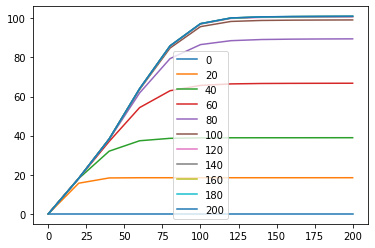

In [38]:
pd.DataFrame(Price_Matrix[100,::20,::20], columns = np.arange(0,200+1)[::20],index = np.arange(0,200+1)[::20]).plot()
plt.legend(loc = 'best')
plt.show()

In [143]:
def Stock_Process(S0,r,dt,sig,div ,number_of_simul, e, M, dtype = np.float32) :
    #############################################
    ## description : MC Stock Simulation Path  ##
    #############################################
    cum_diffusion = (sig * np.sqrt(dt) * np.concatenate([np.zeros((1,number_of_simul)), e], axis = 0 )).astype(np.float32).cumsum(0)
    cum_drift = ((r-div - 0.5 * sig **2 ) * np.concatenate([np.zeros((1,1)),np.ones((M,1))],axis = 0) * dt).astype(np.float32).cumsum(0)
    price = S0 * np.exp( cum_drift + cum_diffusion )
    return price 

def MC_price(std_x_K,std_x_KI, std_y_K, std_y_KI, std_z_K, std_z_KI,
            rhoxy,rhoyz,rhoxz,r_curve,Dx,Dy,Dz,
             cr_ary,K_ary,KI_ary,T,
             number_of_simul = 10000,S0 = 100,days_C_to_C = 125,F=100) :
    KI = np.concatenate([np.repeat(KI_ary, days_C_to_C).reshape(-1,1),np.zeros((1,1))], axis = 0)
    Frate = Fd_rate(r_curve,T)
    F_Vol_x_KI,  F_Vol_x_NKI  =  Calculate_F_Vol(std_x_K, std_x_KI, T)
    F_Vol_y_KI,  F_Vol_y_NKI  =  Calculate_F_Vol(std_y_K, std_y_KI, T)
    F_Vol_z_KI,  F_Vol_z_NKI  =  Calculate_F_Vol(std_z_K, std_z_KI, T)

    pp = days_C_to_C
    DF = np.exp(-(np.repeat(T/len(cr_ary), len(cr_ary)) * Frate)).cumprod()
    KIS0= KI * S0
    M = len(cr_ary) * pp

    r = np.concatenate([[0],np.repeat(Frate , days_C_to_C)]).reshape(-1,1).astype(np.float32)
    cov = [[1,rhoxy, rhoxz],
          [rhoxy, 1, rhoyz],
          [rhoxz, rhoyz, 1]]
    Time_number = M
    t = T/Time_number
    Time_space = np.linspace(0,T,Time_number+1).astype(np.float32).reshape(-1,1)
    multinorm = np.random.multivariate_normal([0,0,0], cov, (Time_number, number_of_simul))

    e = multinorm.transpose(0,2,1).astype(np.float32)
    ex, ey, ez = e[:,0,:] , e[:,1,:], e[:,2,:]
    sigx_NKI = np.concatenate([[0],np.repeat(F_Vol_x_NKI, days_C_to_C)]).reshape(-1,1)
    sigy_NKI = np.concatenate([[0],np.repeat(F_Vol_y_NKI, days_C_to_C)]).reshape(-1,1)
    sigz_NKI = np.concatenate([[0],np.repeat(F_Vol_z_NKI, days_C_to_C)]).reshape(-1,1)
    price_x = Stock_Process(S0, r, t, sigx_NKI, Dx, number_of_simul, ex, M)
    price_y = Stock_Process(S0, r, t, sigy_NKI, Dy, number_of_simul, ey, M)
    price_z = Stock_Process(S0, r, t, sigz_NKI, Dz, number_of_simul, ez, M)

    min_price = np.minimum(np.minimum(price_x, price_y), price_z)

    sigx_KI = np.concatenate([[0],np.repeat(F_Vol_x_KI , days_C_to_C)]).reshape(-1,1)
    sigy_KI = np.concatenate([[0],np.repeat(F_Vol_y_KI , days_C_to_C)]).reshape(-1,1)
    sigz_KI = np.concatenate([[0],np.repeat(F_Vol_z_KI , days_C_to_C)]).reshape(-1,1)
    KI_matrix = np.concatenate([(min_price[:-1]<KI[:-1] * S0).cumsum(0).cumsum(0) >1, ((min_price[:-1]<KI[:-1] * S0).cumsum(0).cumsum(0) >1)[-1:]], axis = 0)
    KI_num = ((min_price[:-1,:]<KI[:-1,:]*S0).sum(0) > 0 ).reshape(1,-1)
    print(KI_num.sum())
    sigx = sigx_NKI * (1-KI_matrix) + sigx_KI * KI_matrix
    sigy = sigy_NKI * (1-KI_matrix) + sigy_KI * KI_matrix
    sigz = sigz_NKI * (1-KI_matrix) + sigz_KI * KI_matrix
    price_x = Stock_Process(S0, r, t, sigx, Dx, number_of_simul, ex, M)
    price_y = Stock_Process(S0, r, t, sigy, Dy, number_of_simul, ey, M)
    price_z = Stock_Process(S0, r, t, sigz, Dz, number_of_simul, ez, M)
    min_price = np.minimum(np.minimum(price_x, price_y), price_z)
    KI_num = ((min_price[:-1,:]<KI[:-1,:]*S0).sum(0) > 0 ).reshape(1,-1)
    NKI_num = 1-KI_num

    Autocall_Value = (F * (1+cr_ary) * DF).reshape(-1,1)
    print(KI_num.sum())
    ## Knuck In Case ##
    ## KI AC
    KI_AC_value = ((min_price[pp-1::pp][:-1]>=(S0*K_ary[:-1]).reshape(-1,1)).cumsum(0).cumsum(0) == 1) * Autocall_Value[:-1] * KI_num
    KI_AC_condition = (KI_AC_value.sum(0)>0).reshape(1,-1)
    ## KI_NAC
    KI_NAC_condition = KI_num ^ KI_AC_condition
    KI_NAC_above_K_condition = ((min_price[-1:] >=K_ary[-1] *S0)*KI_NAC_condition)
    KI_NAC_above_K_value = KI_NAC_above_K_condition* Autocall_Value[-1]
    KI_NAC_below_K_condition = ((min_price[-1:] <K_ary[-1] *S0) * KI_NAC_condition)
    KI_NAC_below_K_value = min_price[-1:,:]/S0 * KI_NAC_below_K_condition * F * DF[-1]
    ## NKI AC
    NKI_AC_value = ((min_price[pp-1::pp][:-1]>=(S0*K_ary[:-1]).reshape(-1,1)).cumsum(0).cumsum(0) == 1 ) * Autocall_Value[:-1] * NKI_num
    NKI_AC_condition = (NKI_AC_value.sum(0)>0).reshape(1,-1)
    ## NKI NAC
    NKI_NAC_condition = NKI_num ^ NKI_AC_condition
    NKI_NAC_above_K_condition = (min_price[-1:,:] >=KI_ary[-1] *S0)*NKI_NAC_condition
    NKI_NAC_above_K_value = NKI_NAC_above_K_condition * Autocall_Value[-1]
    NKI_NAC_below_K_condition = (min_price[-1:,:]<KI_ary[-1]*S0)*NKI_NAC_condition
    NKI_NAC_below_K_value = min_price[-1:,:]/S0 * NKI_NAC_below_K_condition * F * DF[-1]
    value = (KI_AC_value.sum(0) +  KI_NAC_above_K_value.sum(0)+ KI_NAC_below_K_value.sum(0)+ NKI_AC_value.sum(0)+ NKI_NAC_above_K_value.sum(0)+ NKI_NAC_below_K_value.sum(0)).mean()
    return value

In [144]:
MC_price(std_x_K,std_x_KI, std_y_K, std_y_KI, std_z_K, std_z_KI,
            rhoxy,rhoyz,rhoxz,r_curve,Dx,Dy,Dz,
             cr_ary,K_ary,KI_ary,T,
             number_of_simul = 10000,S0 = 100,days_C_to_C = 125)

3916
3916


95.87996855968036

### Constant Elasticity of Variance model (CEV)

$$
\begin{array}{c}
\\
dS = \mu S dt + \omega \sqrt{S} dW \\
\\
\frac{dS}{S} = \mu dt + \frac{\omega}{\sqrt{S}} dW
\\
\end{array}
$$

### PDE of CEV

$$
\begin{array}{c}
\\
\frac{1}{2} \omega^2 S \frac{ {\delta}^2 F}{\delta S^2} + \frac{\delta F}{t} - rF + S(r-d)\frac{\delta F}{\delta S} = 0
\\
\end{array}
$$

### 3d PDF of CEV
$$
\begin{array}{c}
\\
\ u_{\tau} = (r-d_{x})xu_{x} + (r-d_{y})yu_{y} + (r-d_{z})zu_{z} \\
\ + \frac{1}{2}(\frac{\omega_x}{\sqrt{x}}x)^{2}u_{xx} 
+ \frac{1}{2}(\frac{\omega_y}{\sqrt{y}}y)^{2}u_{yy}
+ \frac{1}{2}(\frac{\omega_z}{\sqrt{z}}z)^{2}u_{zz}\\
\ + \rho_{xy}\frac{\omega_x}{\sqrt{x}}\frac{\omega_y}{\sqrt{y}}xyu_{xy} + \rho_{yz}\frac{\omega_y}{\sqrt{y}}\frac{\omega_z}{\sqrt{z}}yzu_{yz}+ \rho_{xz}\frac{\omega_z}{\sqrt{z}}\frac{\omega_x}{\sqrt{x}}zxu_{xz} - ru \\\
\\
\end{array}
$$


In [107]:
def ELS_Matrix_CEV(w_x,w_y,w_z,rhoxy, rhoyz, rhoxz, 
                   r_curve, Dx,Dy,Dz,                   
                   cr_ary, K_ary, KI_ary, T, h = 1/12,
                   S0=100,max_multiple = 2, F = 100) :
    ####################
    ## Basic Variables##
    ####################
    N = int(S0 * max_multiple)
    KI = KI_ary[::-1][0]
    K = K_ary[-1]
    n   ,Xshape   ,Yshape   ,Zshape = np.arange(0,N+1, dtype = np.float32) ,(-1,1,1) , (1,-1,1), (1,1,-1)
    ##################
    ## Final Payoff ##
    ##################
    K0_condition              = (n<=S0 * K).sum() 
    U_tau = np.minimum(np.minimum((F * n/S0).reshape(Xshape) , (F* n/S0).reshape(Yshape)) , (F * n/S0).reshape(Zshape))
    U_tau[K0_condition:, K0_condition:, K0_condition:] =  F * (1+cr_ary[::-1][0])
    KI_condition              = (n<S0 * KI).sum() 
    U_tau_NKI = np.minimum(np.minimum((F * n/S0).reshape(Xshape) , (F* n/S0).reshape(Yshape)) , (F * n/S0).reshape(Zshape))
    U_tau_NKI[KI_condition:, KI_condition:, KI_condition:] =  F * (1+cr_ary[::-1][0])
    Frate = Fd_rate(r_curve, T)
    sigx, sigy, sigz = (w_x * n[1:-1]**-0.5), (w_y * n[1:-1]**-0.5), (w_z * n[1:-1]**-0.5)
    r = Frate[-1].astype(np.float32)    
    Inv_diag , Inv_diag2, Inv_diag3= Inv_tdiag(h,r,Dx,n[1:-1],sigx) , Inv_tdiag(h,r,Dy,n[1:-1],sigy) , Inv_tdiag(h,r,Dz,n[1:-1],sigz)
    #### Jit compile ###
    Calculate_d_CEV(U_tau, n, n, n, sigx, sigy, sigz, rhoxy, rhoyz, rhoxz, h)
    Calculate_Next_U_CEV(U_tau, n, n, n, sigx, sigy, sigz, rhoxy, rhoyz, rhoxz, h, Inv_diag)    
    t = 0
    C_day_Count = 0
    for i in range(int(1/h * T)) : 
        t = t+1
        ####################### KI Case Matrix ###################
        U_tau = Calculate_Next_U_CEV(U_tau, n, n, n, sigx, sigy, sigz, rhoxy, rhoyz, rhoxz, h, Inv_diag) # t + 1/3dt
        U_tau = Calculate_Next_U_CEV(U_tau, n, n, n, sigy, sigz, sigx, rhoyz, rhoxz, rhoxy, h, Inv_diag2)# t + 2/3dt
        U_tau = Calculate_Next_U_CEV(U_tau, n, n, n, sigz, sigx, sigy, rhoxz, rhoxy, rhoyz, h, Inv_diag3)# t + dt
        ###################### NKI Case Matrix ####################
        U_tau_NKI = Calculate_Next_U_CEV(U_tau_NKI, n, n, n, sigx, sigy, sigz, rhoxy, rhoyz, rhoxz, h, Inv_diag)
        U_tau_NKI = Calculate_Next_U_CEV(U_tau_NKI, n, n, n, sigy, sigz, sigx, rhoyz, rhoxz, rhoxy, h, Inv_diag2) 
        U_tau_NKI = Calculate_Next_U_CEV(U_tau_NKI, n, n, n, sigz, sigx, sigy, rhoxz, rhoxy, rhoyz, h, Inv_diag3)
        if t*h * 12 >= 6 and  i < int(1/h * T  - 1) :
            C_day_Count +=1
            t = 0
            K = K_ary[::-1][C_day_Count]  
            K_S0= S0*K
            K0_Condition = (n <= K_S0).sum()
            U_tau[K0_Condition:, K0_Condition:, K0_Condition:] = (F * (1+cr_ary[::-1][C_day_Count]))
            U_tau_NKI[K0_Condition:, K0_Condition:, K0_Condition:] = (F * (1+cr_ary[::-1][C_day_Count]))
            print(6-C_day_Count,"쿠폰지급")
            ###########################################################
            KI = KI_ary[::-1][C_day_Count] 
            r = Frate[::-1][C_day_Count]
            KI_condition              = (n<S0 * KI).sum() 
        U_tau_NKI = Overwrite_NKI_matrix(U_tau_NKI,U_tau,KI_condition)
        print('time : ',t*h,'  min ',U_tau_NKI.min())  
    return U_tau_NKI


In [108]:
Tickers = ['EURO STOXX 50','홍콩 H','S&P 500']
w_x , w_y , w_z = Calculate_w(r'C:\Users\ciiad\3d_ELS\IMVOL_DATA.xlsx',Tickers )
rhoxy  = Corr_data['EURO STOXX 50'].loc['홍콩 H']
rhoyz  = Corr_data['홍콩 H'].loc['S&P 500']
rhoxz  = Corr_data['S&P 500'].loc['EURO STOXX 50'] 
r_curve     =  np.array([0.02 , 0.02155, 0.0228, 0.0238, 0.0243, 0.0247 ]) # Interest Rate Term Structure [T = 0.5 to 3]
Dx , Dy, Dz = 0.031,0.032,0.026
Coupon_Rate = 0.075
cr_ary      =  np.arange(0.5,3.5,0.5) * Coupon_Rate
K_ary       =  np.array([0.9,  0.85,   0.85,   0.80,  0.75,  0.70  ])
KI_ary = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
T = 3

In [141]:
Price_Matrix_CEV = ELS_Matrix_CEV(w_x,w_y,w_z,rhoxy, rhoyz, rhoxz, 
                                  r_curve, Dx,Dy,Dz,                   
                                  cr_ary, K_ary, KI_ary, T, h = 1/250,
                                  S0=100,max_multiple = 2, F = 100)

time :  0.004   min  0.0
time :  0.008   min  0.0
time :  0.012   min  0.0
time :  0.016   min  0.0
time :  0.02   min  0.0
time :  0.024   min  0.0
time :  0.028   min  0.0
time :  0.032   min  0.0
time :  0.036000000000000004   min  0.0
time :  0.04   min  0.0
time :  0.044   min  0.0
time :  0.048   min  0.0
time :  0.052000000000000005   min  0.0
time :  0.056   min  0.0
time :  0.06   min  0.0
time :  0.064   min  0.0
time :  0.068   min  0.0
time :  0.07200000000000001   min  0.0
time :  0.076   min  0.0
time :  0.08   min  0.0
time :  0.084   min  0.0
time :  0.088   min  0.0
time :  0.092   min  0.0
time :  0.096   min  0.0
time :  0.1   min  0.0
time :  0.10400000000000001   min  0.0
time :  0.108   min  0.0
time :  0.112   min  0.0
time :  0.116   min  0.0
time :  0.12   min  0.0
time :  0.124   min  0.0
time :  0.128   min  0.0
time :  0.132   min  0.0
time :  0.136   min  0.0
time :  0.14   min  0.0
time :  0.14400000000000002   min  0.0
time :  0.148   min  0.0
time :  0.1

time :  0.228   min  0.0
time :  0.232   min  0.0
time :  0.23600000000000002   min  0.0
time :  0.24   min  0.0
time :  0.244   min  0.0
time :  0.248   min  0.0
time :  0.252   min  0.0
time :  0.256   min  0.0
time :  0.26   min  0.0
time :  0.264   min  0.0
time :  0.268   min  0.0
time :  0.272   min  0.0
time :  0.276   min  0.0
time :  0.28   min  0.0
time :  0.28400000000000003   min  0.0
time :  0.28800000000000003   min  0.0
time :  0.292   min  0.0
time :  0.296   min  0.0
time :  0.3   min  0.0
time :  0.304   min  0.0
time :  0.308   min  0.0
time :  0.312   min  0.0
time :  0.316   min  0.0
time :  0.32   min  0.0
time :  0.324   min  0.0
time :  0.328   min  0.0
time :  0.332   min  0.0
time :  0.336   min  0.0
time :  0.34   min  0.0
time :  0.34400000000000003   min  0.0
time :  0.34800000000000003   min  0.0
time :  0.352   min  0.0
time :  0.356   min  0.0
time :  0.36   min  0.0
time :  0.364   min  0.0
time :  0.368   min  0.0
time :  0.372   min  0.0
time :  0.376

time :  0.452   min  0.0
time :  0.456   min  0.0
time :  0.46   min  0.0
time :  0.464   min  0.0
time :  0.468   min  0.0
time :  0.47200000000000003   min  0.0
time :  0.47600000000000003   min  0.0
time :  0.48   min  0.0
time :  0.484   min  0.0
time :  0.488   min  0.0
time :  0.492   min  0.0
time :  0.496   min  0.0
1 쿠폰지급
time :  0.0   min  0.0
time :  0.004   min  0.0
time :  0.008   min  0.0
time :  0.012   min  0.0
time :  0.016   min  0.0
time :  0.02   min  0.0
time :  0.024   min  0.0
time :  0.028   min  0.0
time :  0.032   min  0.0
time :  0.036000000000000004   min  0.0
time :  0.04   min  0.0
time :  0.044   min  0.0
time :  0.048   min  0.0
time :  0.052000000000000005   min  0.0
time :  0.056   min  0.0
time :  0.06   min  0.0
time :  0.064   min  0.0
time :  0.068   min  0.0
time :  0.07200000000000001   min  0.0
time :  0.076   min  0.0
time :  0.08   min  0.0
time :  0.084   min  0.0
time :  0.088   min  0.0
time :  0.092   min  0.0
time :  0.096   min  0.0
time

In [142]:
Price_Matrix_CEV[100,100,100]

97.14318

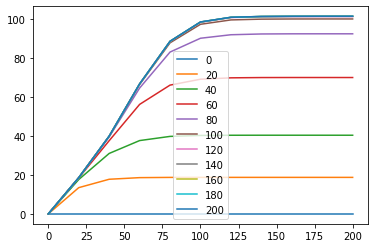

In [140]:
pd.DataFrame(Price_Matrix_CEV[100,::20,::20], columns = np.arange(0,200+1)[::20],index = np.arange(0,200+1)[::20]).plot()
plt.legend(loc = 'best')
plt.show()